In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports and utilities

In [2]:
from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import entropy as calculate_entropy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [3]:
# total number of samples needed
datasize = 50
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']
label_classes = ['autos', 'religion', 'graphics', 'space']

assert len(label_classes) == len(categories)

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### Clean and preprocess Documents

In [4]:
labels = []
clean_docs = []
all_docs = []
max_document_length = None

# the new classes
sizes = [0] * len(label_classes)
assert len(label_classes) == len(sizes)

for index, doc in enumerate(docs):    
    cd = clean_doc(doc)
    if len(cd) == 0 or cd.isspace() or (max_document_length is not None and len(cd) <= max_document_length):
        continue
    
    all_docs.append(cd)
    
    if len(clean_docs) == datasize*len(label_classes):
        continue
        
    label_class = classes[old_labels[index]]
    label = categories.index(label_class)

    if sizes[label] < datasize:
        clean_docs.append(cd)
        labels.append(label)

        sizes[label] += 1

labels = np.array(labels)
print(clean_docs[0])

apparently you re not a woman   my husband hates the auto door locks
 feels safer in a car that locks easily  in addition to watching around
 in a secluded spot  etc   have my keys ready to open the door so i m


In [5]:
print(f"there are {len(all_docs)} corpus docs and {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes} of size min:{min(sizes)}, max:{max(sizes)}")

there are 2069 corpus docs and 200 docs and 4 classes: ['autos', 'religion', 'graphics', 'space'] of size min:50, max:50


### Prepare Vectorizer

In [6]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)

count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 4782


### Prepare All docs Vectors

In [7]:
# create doc count vectors
all_doc_vectors = count_vectorizer.transform(all_docs).toarray()
all_doc_vectors = (all_doc_vectors > 0).astype(float)
all_doc_vectors = normalize(all_doc_vectors, norm="l1", axis=1)

print(f"{len(all_docs)} docs in corpus")

2069 docs in corpus


### Word-Word Ratio

In [8]:
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_freqency = pd.DataFrame(all_doc_vectors, columns=vocabulary)
word_doc_total_frequency = word_doc_freqency.sum(0)

for word in tqdm(vocabulary):
    word_word_frequency = word_doc_freqency[word_doc_freqency[word] > 0].sum(0)
    word_word_co[word] = (word_word_frequency / word_doc_total_frequency).fillna(0)

word_trust_factor = sigmoid(word_word_co.std(1))
print(f"word_word_co has shape {word_word_co.shape}")


word_word_co has shape (4782, 4782)


In [9]:
word_word_co.head()

,000,03051,077,0865,10,100,1000,1000r,101010,102,...,your,yours,yourself,yourselfers,yoyodyne,z1dan,zealots,zero,zeus,zion
000,1.000000,0.0,0.0,0.0,0.215775,0.099363,0.044933,0.0,0.0,0.019396,...,0.219190,0.000000,0.041307,0.0,0.0,0.0,0.0,0.003717,0.0,0.0
03051,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
077,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
0865,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
10,0.135879,0.0,0.0,0.0,1.000000,0.067077,0.024621,0.0,0.0,0.012214,...,0.230567,0.009899,0.022876,0.0,0.0,0.0,0.0,0.012126,0.0,0.0


In [10]:
word = 'computer'
word_word_co[word].sort_values(ascending=False)

adaptive       1.0
checkup        1.0
93430          1.0
aurenhammer    1.0
diner          1.0
              ... 
nx2000         0.0
doth           0.0
dots           0.0
nuts           0.0
zion           0.0
Name: computer, Length: 4782, dtype: float64

In [11]:
word_word_co.loc[word].sort_values(ascending=False)

computer       1.000000
of             0.808670
the            0.800807
and            0.756772
to             0.713378
                 ...   
reliability    0.000000
relevance      0.000000
finhuc         0.000000
finhutc        0.000000
zion           0.000000
Name: computer, Length: 4782, dtype: float64

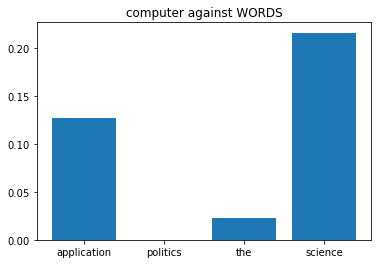

In [12]:
plt.title(f"{word} against WORDS")
words = ["application", "politics", "the", "science"]
plt.bar(words, word_word_co[word][words])
plt.show()

In [13]:
vocabulary[word_trust_factor.argmax()], word_trust_factor.max(), (all_doc_vectors[:, word_trust_factor.argmax()] > 0).sum()

('abounded', 0.5831518316271094, 1)

In [14]:
ratios = []
for w in words:
    ratio = word_trust_factor[vocabulary.index(w)]
    ratios.append(ratio)
    
    print('%16s'%w, round(ratios[-1], 4))
ratios = np.array(ratios)

     application 0.5149
        politics 0.512
             the 0.5085
         science 0.5141


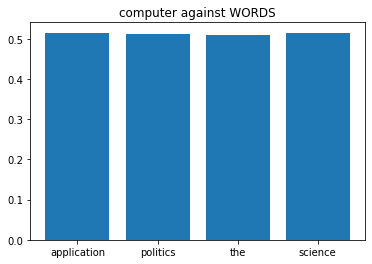

In [15]:
plt.title(f"{word} against WORDS")
plt.bar(words, ratios)
plt.show()

### Prepare Train/test Vectors

In [16]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
train_doc_vectors = (train_doc_vectors > 0).astype(float)
train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
test_doc_vectors = (test_doc_vectors > 0).astype(float)
test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

134 train_docs, 66 test docs


### Prepare training data

In [17]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=vocabulary)
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (134, 4783)


In [18]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 200 docs and 4 classes


In [19]:
document_word_frequency.head()

,000,03051,077,0865,10,100,1000,1000r,101010,102,...,yours,yourself,yourselfers,yoyodyne,z1dan,zealots,zero,zeus,zion,__labels__
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.008696,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.006289,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


### Topic and word corelation

In [21]:
word_doc_freqency = document_word_frequency.drop(["__labels__"], axis='columns')
word_doc_total_frequency = word_doc_freqency.sum(0)

topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid((word_doc_freqency > 0).sum(0)) * word_trust_factor
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_total_frequency).fillna(0)

print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (4782, 4)


In [ ]:
topic_word_distr.head()

In [521]:
label_classes

['autos', 'religion', 'graphics', 'space']

In [522]:
label_class = 'graphics'
topic_word_distr[label_class].sort_values(ascending=False)

code        0.257500
software    0.256199
hi          0.255995
images      0.255743
video       0.254217
              ...   
nucleus     0.000000
nuclear     0.000000
nsc         0.000000
nowhere     0.000000
000         0.000000
Name: graphics, Length: 4782, dtype: float64

In [523]:
word="computer"
topic_word_distr.loc[word].sort_values(ascending=False)

graphics    0.162605
autos       0.094508
space       0.000000
religion    0.000000
Name: computer, dtype: float64

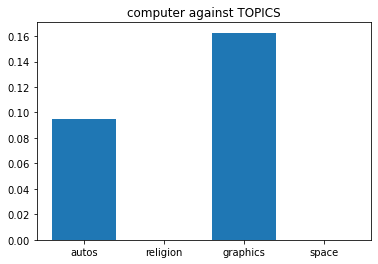

In [524]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluate Topic model with Train set

In [525]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 100.00%, 0 misclassified



### Evaluating Topic Model with test set

In [526]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 74.24%, avg-accuarcy = 87.12%, 17 misclassified



### Using Multinomial Naive Bayes

In [527]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

train_accuracy = clf.score(train_doc_vectors, train_labels)
test_accuracy = clf.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

training_accuarcy = 100.00%, test_accuarcy = 60.61%, avg-accuarcy = 80.30%
